# 2차시: RNN(순환신경망)을 이용한 감정 분류
#### Import

In [1]:
!pip install --upgrade git+https://github.com/dAiv-CNU/torchdaiv.git konlpy gensim

  Cloning https://github.com/dAiv-CNU/torchdaiv.git to /tmp/pip-req-build-fy0xhdu0
  Running command git clone --filter=blob:none --quiet https://github.com/dAiv-CNU/torchdaiv.git /tmp/pip-req-build-fy0xhdu0
  Resolved https://github.com/dAiv-CNU/torchdaiv.git to commit 20d31332218bbd1c73bf447ce50b2dabebaf9a28
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached torchvision-0.18.0-cp310-cp310-manylinux1_x86_64.whl (7.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchdaiv import datasets
from torchdaiv.lectures.emotion import nn
from torchdaiv.lectures.emotion.util import vocabulary, transforms

from rich.traceback import install
install(show_locals=True)

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x00000299F26F0A10>>

#### Load Dataset

In [3]:
# 데이터셋 로드 - 아무 처리도 하지 않았을 때
train_dataset = datasets.EmotionDataset("./data", download=False, train=True, sentiment=True)
test_dataset = datasets.EmotionDataset("./data", download=False, train=False, sentiment=True)

In [4]:
# 데이터셋 형태 확인
for i, (text, emotion) in zip(range(20), train_dataset):
    print(f"{i}: {text} -> {emotion}")

0: 가격이 착하고 -> 긍정
1: 디자인이 예쁩니다 -> 긍정
2: 싸고 -> 긍정
3: 디자인이 예뻐요 -> 긍정
4: 가성비 가심비 입니다 -> 긍정
5: 편하고 -> 긍정
6: 디자인이 예뻐요 -> 긍정
7: 가격도  좋아요 -> 긍정
8: 시원해요 -> 긍정
9: 빨리 마르고 -> 긍정
10: 이것만  입게되요 -> 긍정
11: 너무 착한가격에 감사합니다 -> 긍정
12: 윈하는 색은 없지만 -> 부정
13: 가격이  너무 좋아서 -> 긍정
14: 소재도  맘에  들어  흰색도  구매했습니다 -> 긍정
15: 재질도 디자인도 좀~그러네요 -> 부정
16: 디자인도 좀~그러네요 -> 부정
17: 집에서 편하게 입을수는 있을것 같아요 -> 중도
18: 자켓이 넘작고 -> 부정
19: 짧으네요. -> 부정


##### 모델 성능 개선 방안 1: 단어를 분리할 때, 형태소 분석기를 사용하여 단어를 분리한다.
    - 지난 주차에는 띄어쓰기를 기준으로 단어를 분리하였다.
    - 이번 주차에는 konlpy 형태소 분석기를 사용하여 의미를 지닌 최소 단위로 단어를 분리한다.
        * morphs: 형태소 단위 분리
        * nouns: 명사만 분리
        * phrases: 구문 단위 분리

In [5]:
# 토크나이저 객체 생성 후 토근화 - 근데 너무 느림 (20분에서 30분 정도?)
#tokenizer = vocabulary.KoNLPyTokenizer(java_path=None)  # 필요한 경우 자바 경로 지정해야 함

#train_dataset.transform(transform=tokenizer.morphs)  # 형태소 단위로 분리
#test_dataset.transform(transform=tokenizer.morphs)

In [6]:
# 대기 시간 단축을 위해 토큰화가 완료된 데이터를 불러오기
tokenizer = vocabulary.KoNLPyTokenizer

train_dataset = tokenizer.from_pretrained(datasets.EmotionDataset, "./data", download=False, train=True, sentiment=True, transform=tokenizer.morphs)  # 형태소 단위로 분리
test_dataset = tokenizer.from_pretrained(datasets.EmotionDataset, "./data", download=False, train=False, sentiment=True, transform=tokenizer.morphs)

In [7]:
# 분리된 데이터셋 형태 확인
for i, (text, emotion) in zip(range(20), train_dataset):
    print(f"{i}: {text} -> {emotion}")

0: ['가격', '이', '착하고'] -> 긍정
1: ['디자인', '이', '예쁩니다'] -> 긍정
2: ['싸고'] -> 긍정
3: ['디자인', '이', '예뻐요'] -> 긍정
4: ['가성', '비', '가심', '비', '입니다'] -> 긍정
5: ['편하고'] -> 긍정
6: ['디자인', '이', '예뻐요'] -> 긍정
7: ['가격', '도', '좋아요'] -> 긍정
8: ['시원해요'] -> 긍정
9: ['빨리', '마르고'] -> 긍정
10: ['이', '것', '만', '입게되', '요'] -> 긍정
11: ['너무', '착한', '가격', '에', '감사합니다'] -> 긍정
12: ['윈하', '는', '색', '은', '없지만'] -> 부정
13: ['가격', '이', '너무', '좋아서'] -> 긍정
14: ['소재', '도', '맘', '에', '들어', '흰색', '도', '구매', '했습니다'] -> 긍정
15: ['재질', '도', '디자인', '도', '좀', '~', '그러네요'] -> 부정
16: ['디자인', '도', '좀', '~', '그러네요'] -> 부정
17: ['집', '에서', '편하게', '입을수는', '있을것', '같아요'] -> 중도
18: ['자켓', '이', '넘', '작고'] -> 부정
19: ['짧으네요', '.'] -> 부정


##### 모델 성능 개선 방안 2: 단어를 숫자로 바꿀 때 워드 임베딩을 사용한다.
    - 지난 주차에는 단어를 컴퓨터가 처리할 수 있도록 단어를 숫자로 바꾸는 방법을 사용하였다.
    - 그러나 이렇게 되면, 단순히 나중에 사전에 등록된 단어일수록 큰 숫자로 지정되어 학습에서 중요도를 크게 가져가게 된다.
    - 이번 주차에는 단어를 숫자로 바꿀 때, 워드 임베딩을 사용하여 단어의 의미를 단순한 숫자가 아니라 벡터 공간에서의 위치로 표현한다.
[구현 예시] [WordVector](https://dreamgonfly.github.io/blog/word2vec-explained/)
<iframe src="https://ronxin.github.io/wevi/" width="100%" height="500px"></iframe>

In [8]:
# 2-1: 단어 사전을 이전 방식과 동일하게 생성한 뒤 모델 내에서 워드 임베딩을 사용
vocab, to_vocab = vocabulary.vocabulary_creator(minimum_frequency=5, tokenizer=None)

train_dataset.transform(transform=to_vocab)
test_dataset.transform(transform=to_vocab)

In [9]:
# 2-2: 단어 사전을 별도의 워드 벡터 모델을 사용하여 생성한 후 모델 내에서 바로 사용
#vocab = vocabulary.WordVector(
#    dataset_list=[train_dataset, test_dataset],  # 워드 벡터를 생성할 데이터 셋 리스트
#    vector_size=10,   # 특징 값 혹은 임베딩 된 벡터의 차원
#    window=5,         # 주변 단어 수
#    min_count=5,      # 단어 최소 빈도 수 / 해당 숫자보다 적은 빈도의 단어들은 사용하지 않음
#    workers=6,        # 학습에 사용되는 프로세스 수
#).wv

##### 토큰 길이 지정

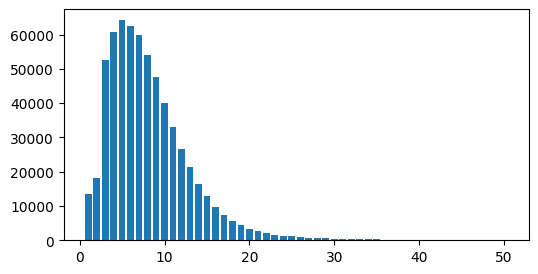

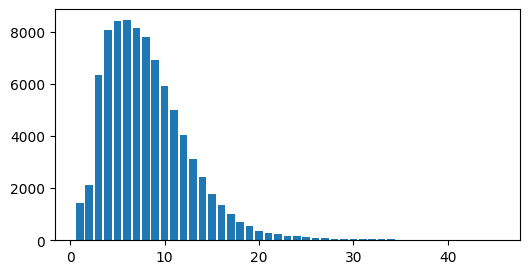

In [10]:
# 데이터를 텐서로 변환
train_dataset.transform(
    transform=transforms.to_tensor(vocabulary=vocab, show_graph=True, normalize=False, tokenizer=None),
    target_transform=transforms.label_to_tensor
)
test_dataset.transform(
    transform=transforms.to_tensor(vocabulary=vocab, show_graph=True, normalize=False, tokenizer=None),
    target_transform=transforms.label_to_tensor
)

In [11]:
# 텐서 길이 조정
##max_token_size = 20
#train_dataset.transform(transform=transforms.size_to(max_token_size))
#test_dataset.transform(transform=transforms.size_to(max_token_size))

In [12]:
# 변환된 데이터 형태 확인
for i, (text, emotion) in zip(range(20), train_dataset):
    print(f"{i}: {text} -> {emotion}")

0: tensor([10065,  6216, 17702,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]) -> tensor([1., 0., 0.])
1: tensor([ 9300,  6216, 23411,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]) -> tensor([1., 0., 0.])
2: tensor([15566,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
     

#### DataLoader

In [13]:
# 배치 크기 결정 후 데이터 로더 생성
batch_size = len(train_dataset) // 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset)//20)

#### Model Definition
##### 단순히 퍼셉트론을 멀티 레이어로 쌓았던 지난번과는 달리, 이번에는 순차 데이터를 처리하도록 설계된 RNN을 사용

In [19]:
# 모델 정의
class MyModel(nn.Module):
    def __init__(self, vocab_size=50, input_size=20, hidden_size=50, output_size=3):
        super().__init__()
        
        # 워드 임베딩 레이어
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=input_size)

        # 순차 데이터 처리를 위한 RNN layer
        # RNN이 내보내는 벡터의 크기는 hidden_size크기와 같다
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        
        # RNN의 출력을 받아서 최종적으로 분류하는 레이어
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 워드 임베딩
        inputs = self.embedding(x)
        
        # RNN 출력
        out, hidden_state = self.rnn(inputs)

        # 분류
        return self.fc(F.tanh(hidden_state))

In [20]:
# 하이퍼 파라미터 설정
epochs = 20
learning_rate = 0.01
input_size = 20
hidden_size = 50

In [21]:
# 모델 생성 및 데이터 로더 지정
model = MyModel(vocab_size=len(vocab), input_size=input_size, hidden_size=hidden_size)
model.set_dataloader(train_dataloader, test_dataloader)
model

MyModel(
  (embedding): Embedding(24480, 20)
  (rnn): RNN(20, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=3, bias=True)
)

In [22]:
# Use CUDA driver if available
if torch.cuda.is_available():
    model.to("cuda", non_blocking=True)
print("Use Device:", model.device.upper())

Use Device: CUDA


#### Training

In [23]:
# Train Dataset에 대해서 학습 시작
model.train(epochs=epochs, optimizer_init=True, lr=learning_rate)

Epoch 1:   0%|          | 0/9840 [00:00<?, ?it/s]

Epoch [1/20], Step: [9840/9840], Accuracy: 34.691735%, Loss: 0.73653823


Epoch 2:   0%|          | 0/9840 [00:00<?, ?it/s]

Epoch [2/20], Step: [9477/9840], Accuracy: 34.877424%, Loss: 0.73644967


KeyboardInterrupt



#### Evaluation

In [ ]:
# Test Dataset에 대해서 평가 진행
model.evaluate()

#### Prediction

In [ ]:
# 토큰화 및 텐서 변환 후 직접 입력한 문장 분류
transform_sequence = [
    transforms.to_tensor(vocabulary=vocab, show_graph=False, normalize=False, tokenizer=None),
    #transforms.size_to(max_token_size)
]

In [ ]:
model.pipeline(message="안녕하세요! 반갑습니다!", transform=transform_sequence)

In [ ]:
model.pipeline(message="이건 좀 아닌거 같음", transform=transform_sequence)

In [ ]:
model.pipeline(message="못 생겼음", transform=transform_sequence)

In [ ]:
model.pipeline(message="잘 받았습니다.", transform=transform_sequence)

In [ ]:
model.pipeline(message="잘 모르겠네요...", transform=transform_sequence)

In [ ]:
model.pipeline(message="색상별로 사이즈가 너무 다르네요 반품귀찮아서 그냥 대충 입으려구요", transform=transform_sequence)

In [ ]:
model.pipeline(message="여름에입긴 더울거같네요 봄.가을용입니다", transform=transform_sequence)

In [ ]:
model.pipeline(message="기대를 안했는데  바지가 생각보다  착용감 편하고 가볍네요", transform=transform_sequence)

In [ ]:
model.pipeline(message="근데 한가지 허리밴드부분이 너무  널어서 좀~  쪼금안 덜  넓었으면 좋겠어요", transform=transform_sequence)

In [18]:
import imp
imp.reload(torchdaiv)

C:\Users\IRACK\AppData\Local\Temp\ipykernel_142984\1256044338.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 import imp                                                                                   │
│ ❱ 2 imp.reload(torchdaiv)                                                                        │
│   3                                                                                              │
│                                                                                                  │
│ ╭─────────────────────────────────────────── locals ───────────────────────────────────────────╮ │
│ │                    batch_size = 1                                                            │ │
│ │                    DataLoader = <class 'torch.utils.data.dataloader.DataLoader'>             │ │
│ │                      datasets = <module 'torchdaiv.datasets' from                            │ │
│ │                                 'C:\\Users\\IRACK\\Desktop\\다이브\\특강\\딥러닝기초         │ │
│ │                                 특강\\src\\torchdaiv\\datasets\\__init__.py'>                │ │
│ │                       emotion = tensor([0., 0., 1.])                                         │ │
│ │                        epochs = 20                                                           │ │
│ │                          exit = <IPython.core.autocall.ZMQExitAutocall object at             │ │
│ │                                 0x000001DE5D374E10>                                          │ │
│ │                             F = <module 'torch.nn.functional' from 'C:\\Program              │ │
│ │                                 Files\\Python311\\Lib\\site-packages\\torch\\nn\\functional… │ │
│ │                   get_ipython = <bound method InteractiveShell.get_ipython of                │ │
│ │                                 <ipykernel.zmqshell.ZMQInteractiveShell object at            │ │
│ │                                 0x000001DE5D370910>>                                         │ │
│ │                   hidden_size = 50                                                           │ │
│ │                             i = 19                                                           │ │
│ │                           imp = <module 'imp' from 'C:\\Program                              │ │
│ │                                 Files\\Python311\\Lib\\imp.py'>                              │ │
│ │                            In = [                                                            │ │
│ │                                 │   '',                                                      │ │
│ │                                 │   'import torch\nimport torch.nn.functional as F\nfrom     │ │
│ │                                 torch.utils.data import DataLo'+207,                         │ │
│ │                                 │   '# 데이터셋 로드 - 아무 처리도 하지 않았을               │ │
│ │                                 때\ntrain_dataset = datasets.EmotionDataset("./data",        │ │
│ │                                 do'+133,                                                     │ │
│ │                                 │   '# 데이터셋 형태 확인\nfor i, (text, emotion) in         │ │
│ │                                 zip(range(20), train_dataset):\n    print('+28,              │ │
│ │                                 │   '# 토크나이저 객체 생성 후 토근화 - 근데 너무 느림       │ │
│ │                                 (20분에서 30분 정도?)\n#tokenizer =                          │ │
│ │                                 vocabulary.KoNLPyTok'+165,                                   │ │
│ │                                 │   '# 대기 시간 단축을 위해 토큰화가 완료된 데이터를        │ │
│ │                                 불러오기\ntokenizer =                                        │ │
│ │                                 vocabulary